This notebook performs analysis on how model checkpoints learn to predict a variable across its percentile 


First, we need to look at the .nc files in the directory `/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data` and look at its structure.


 
- `var`: variable from ERA5 dataset to analyze
- `percentiles`: array of percentiles to analyze e.g. [90, 91, ..., 100]
- `grid_cell_latlon`: specific grid cell latitude and longitude to analyze percentiles

1. For the global ERA5 truth data of the variable `var`, compute the specified percentiles across the entire training period (1979-2015)
- the percentiles are defined as where the truth falls in or above the given percentile
- specifically we are computing which values of the variable `var` define the edges of each percentile bin

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import Stamen
from tqdm import tqdm
from datetime import datetime, timedelta
import os
import json
from typing import List
import sys
sys.path.append('/projectnb/eb-general/wade/sfno/Example_Code/')
from utils import *
sys.path.append(".")  # Add current directory to Python path

# OLD CODE SNIPPET BELOW. SEE ../save_percentiles.ipynb FOR UPDATED VERSION

```python

In [2]:
# Grid cells for analyzing percentiles
grid_cell_latlon = [
    # (lat, lon)
    (34, -116+360),  # southwestern US, SoCal 
    # (51.5, -0.75+360), # Northern Europe, London.  
    # (27.0,  278.25),  # Southern Florida, Miami where Ian made landfall
]
var = "VAR_2T" # "MSL"
percentiles = np.arange(0,101)  # 0 to 100. 0th percentile -- minimum observed value. 100th percentile -- maximum observed value.
# add .1 increments to the percentiles between 0 and 1, and between 99 and 100
percentiles = np.unique(np.round(np.sort(np.concatenate([np.arange(0,1,0.1), percentiles, np.arange(99.1,100,0.1)])),decimals=1))
print(f"Percentiles to compute: {percentiles}")


Percentiles to compute: [  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    2.
   3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.
  15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.
  27.   28.   29.   30.   31.   32.   33.   34.   35.   36.   37.   38.
  39.   40.   41.   42.   43.   44.   45.   46.   47.   48.   49.   50.
  51.   52.   53.   54.   55.   56.   57.   58.   59.   60.   61.   62.
  63.   64.   65.   66.   67.   68.   69.   70.   71.   72.   73.   74.
  75.   76.   77.   78.   79.   80.   81.   82.   83.   84.   85.   86.
  87.   88.   89.   90.   91.   92.   93.   94.   95.   96.   97.   98.
  99.   99.1  99.2  99.3  99.4  99.5  99.6  99.7  99.8  99.9 100. ]


In [3]:
colors=['crimson','olivedrab']

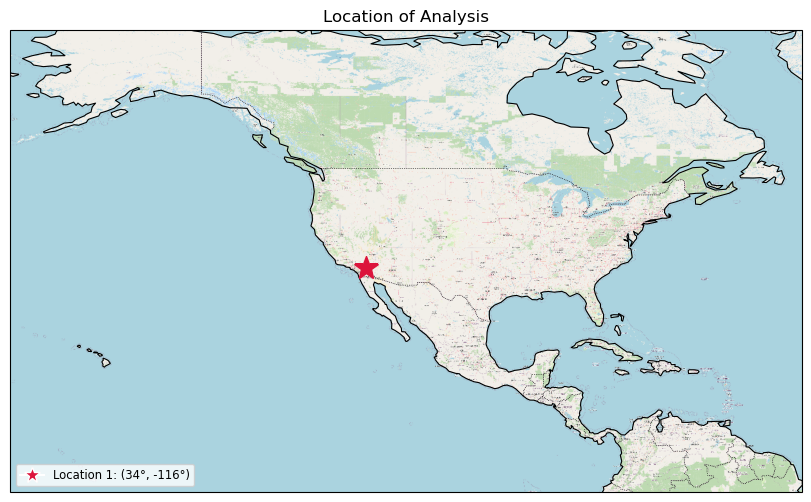

In [6]:
from cartopy.io.img_tiles import OSM
from matplotlib.lines import Line2D

# Plot the grid cell locations on a cartopy map
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Use OpenStreetMap (OSM) as a replacement for satellite imagery
osm_tiles = OSM()
ax.add_image(osm_tiles, 6)  # Adjust zoom level as needed

# Add coastlines and borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Set extent to the northern hemisphere
ax.set_extent([-170, -50, 0, 70], crs=ccrs.PlateCarree())

# Plot grid cell locations
legend_elements = []  # To store legend entries
for ind, (lat, lon) in enumerate(grid_cell_latlon):
    ax.plot(lon if lon <= 180 else lon - 360, lat, marker='*', color=colors[ind], markersize=18,
            transform=ccrs.PlateCarree())
    # Add a legend entry for each marker
    legend_elements.append(Line2D([0], [0], marker='*', color='w', markerfacecolor=colors[ind],
                                   markersize=12, label=f'Location {ind+1}: ({lat}°, {lon if lon <= 180 else lon - 360}°)'))

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='lower left', fontsize='small')

plt.title('Location of Analysis')
plt.savefig('./figs/location.png', dpi=300)
plt.show()

Get data for one grid cell across all time steps, and order the data, define the percentiles, then save the values at each percentile to a new .nc file.



In [11]:
six_hourly_dir = '/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data/6_hourly/'
if var == "VAR_2T":
    six_hourly_dir += '2t/'
else:
    six_hourly_dir += var.lower() + '/'
file_names = [path for path in os.listdir(six_hourly_dir) if not os.path.isdir(path) and path.endswith('.nc')]
file_names.sort()
print(min(file_names), max(file_names))

# # filter files to start with 201001
# file_names = [f for f in file_names if f >= 'e5_2t_201001.nc']
# print(min(file_names), max(file_names))

e5_2t_197901.nc e5_2t_201512.nc


In [9]:
fp = os.path.join(six_hourly_dir, file_names[0])

ds = xr.open_dataset(fp,engine="netcdf4")
ds

<xarray.Dataset> Size: 515MB
Dimensions:    (time: 124, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 992B 1979-01-01 ... 1979-01-31T18:00:00
Data variables:
    MSL        (time, latitude, longitude) float32 515MB ...
    utc_date   (time) int32 496B ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper05 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon May 13 19:16:31 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon May 13 19:17:03 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.4 (http://nco.sf.net)

In [7]:
# Save an array with the time series data for each grid cell
all_time_series = {}
for lat,lon in grid_cell_latlon:
    time_series = []
    for file_name in tqdm(file_names):
        fp = os.path.join(six_hourly_dir, file_name)
        ds = xr.open_dataset(fp,engine="netcdf4")
        data_point = ds[var].sel(latitude=lat, longitude=lon)
        month_data = data_point.values
        time_series.extend(month_data)
        ds.close()
    all_time_series[f'lat{lat}_lon{lon}'] = np.array(time_series)

100%|██████████| 444/444 [05:01<00:00,  1.47it/s]


In [8]:
# save the all_time_series dict to a file
np.save(f'./time_series_{var}_all_grid_cells.npy', all_time_series)

In [15]:
# load the time series data in
all_time_series = np.load(f'./time_series_{var}_all_grid_cells.npy', allow_pickle=True).item()

In [ ]:
#### this code was already run
# loop through files, select the data for that month at the grid cell, and add to a time series array
plt.figure()
for lat,lon in grid_cell_latlon:
    time_series = []
    for file_name in file_names:
        fp = os.path.join(six_hourly_dir, file_name)
        ds = xr.open_dataset(fp,engine="netcdf4")
        data_point = ds[var].sel(latitude=lat, longitude=lon)
        month_data = data_point.values
        time_series.extend(month_data)
        ds.close()
    time_series = np.array(time_series)
    # compute percentiles
    pct_values = np.percentile(time_series, percentiles) # first axis of the result corresponds to the percentiles
    # plot for this grid cell, what the percentile values are
    
    plt.plot(percentiles, pct_values-273.15, 'o', label=f'lat {lat}, lon {lon}')

    # save the percentile values to a json file
    pct_dict = {str(p): float(v) for p, v in zip(percentiles, pct_values)}
    with open(f'./percentile_values/percentiles_{var}_lat{lat}_lon{lon}_0.1_res_at_tails.json', 'w') as f:
        json.dump(pct_dict, f)
    print(f'Saved percentiles for lat {lat}, lon {lon} to json.')

plt.xlabel('Percentile')
plt.ylabel(f'{var} Value')
plt.title(f'Percentiles of {var} at grid cells based on 1979-2015 record')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f'./figs/percentiles_{var}.png', dpi=300)
plt.close()
    

In [36]:
plt.figure()
for lat,lon in tqdm(grid_cell_latlon):
    time_series = all_time_series[f'lat{lat}_lon{lon}']
    # compute percentiles
    pct_values = np.percentile(time_series, percentiles) # first axis of the result corresponds to the percentiles
    # plot for this grid cell, what the percentile values are
    
    plt.plot(percentiles, pct_values-273.15, 'o', label=f'lat {lat}, lon {lon}')

    # save the percentile values to a json file
    pct_dict = {str(p): float(v) for p, v in zip(percentiles, pct_values)}
    with open(f'./percentile_values/percentiles_{var}_lat{lat}_lon{lon}_0.1_res_at_tails.json', 'w') as f:
        json.dump(pct_dict, f)
    print(f'Saved percentiles for lat {lat}, lon {lon} to json.')

plt.xlabel('Percentile')
plt.ylabel(f'{var} Value')
plt.title(f'Percentiles of {var} at grid cells based on 1979-2015 record')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f'./figs/percentiles_{var}.png', dpi=300)
plt.close()

100%|██████████| 2/2 [00:00<00:00, 121.47it/s]


Saved percentiles for lat 34, lon 244 to json.
Saved percentiles for lat 51.5, lon 359.25 to json.


In [33]:
def get_percentile_values_fp(lat, lon):
    return f'./percentile_values/percentiles_{var}_lat{lat}_lon{lon}_0.1_res_at_tails.json'

In [14]:
# open the percentiles files and plot them together for comparison
plt.figure()
for ind, (lat, lon) in enumerate(grid_cell_latlon):
    with open(get_percentile_values_fp(lat,lon), 'r') as f:
        pct_dict = json.load(f)
    pct_values = [pct_dict[str(p)] for p in percentiles]
    plt.plot(percentiles, np.array(pct_values)-273.15, 'o', color=colors[ind], label=f'lat {lat}, lon {lon}')
plt.xlabel('Percentile')
plt.ylabel(f'{var} Value')
plt.title(f'Percentiles of {var} based on 1979-2015 record')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f'./figs/percentiles_{var}_comparison.png', dpi=300)
plt.close()


In [13]:
os.path.join(six_hourly_dir, file_names[0])

'/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data/6_hourly/2t/e5_2t_197901.nc'

### Figure 2a from paper

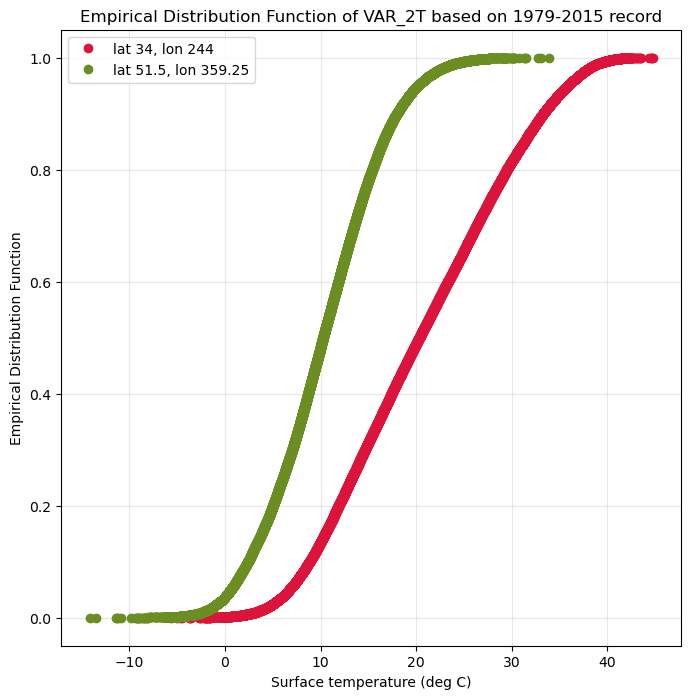

In [16]:
# Make a scatter plot for the two grid cells time series, where the points are ordered by percentile value
fig,ax = plt.subplots(figsize=(8,8))
for ind, (lat, lon) in enumerate(grid_cell_latlon):
    # with open(get_percentile_values(lat,lon), 'r') as f:
    #     pct_dict = json.load(f)
    # pct_values = [pct_dict[str(p)] for p in percentiles]
    time_series = all_time_series[f'lat{lat}_lon{lon}']
    # get the indices that would sort the time series
    sorted_indices = np.argsort(time_series)
    sorted_time_series = time_series[sorted_indices]
    # make an array of the empirical distribution function, where each value increases by 1/N
    edf = np.arange(1, len(sorted_time_series)+1) / len(sorted_time_series)
    ax.plot(sorted_time_series-273.15, edf, 'o', color=colors[ind],
     label=f'lat {lat}, lon {lon}')

ax.set_xlabel(f'Surface temperature (deg C)')
ax.set_ylabel('Empirical Distribution Function')
ax.set_title(f'Empirical Distribution Function of {var} based on 1979-2015 record')
ax.legend()
ax.grid(alpha=0.3)
plt.savefig(f'./figs/edf_{var}_comparison.png', dpi=300)
plt.show()

In [17]:
# For each of the percentiles (1 to 99), calculate the return period of that percentile, where 
# the return period is defined by the average number of years between exceedances of that percentile value.
return_periods = {}
num_years = int(max(file_names).split('_')[-1].split('.')[0][:4]) - int(min(file_names).split('_')[-1].split('.')[0][:4]) + 1
print(f'Calculating return periods based on {num_years} years of data.')

Calculating return periods based on 37 years of data.


In [38]:
# analyze return periods for each percentile and each grid cell
# use the percentiles already calculated in the .json files
for lat, lon in grid_cell_latlon:
    # print(f'Calculating return periods for lat {lat}, lon {lon}...')
    with open(get_percentile_values_fp(lat,lon), 'r') as f:
        pct_dict = json.load(f)
    pct_values = [pct_dict[str(p)] for p in percentiles]
    time_series = all_time_series[f'lat{lat}_lon{lon}']
    print('min and max in time series', min(time_series), max(time_series))

    rp_for_grid_cell = {}
    for p, pct_value in zip(percentiles, pct_values):  
        print('percentile value:', pct_value, 'first time series value:', time_series[0])
        exceedances = np.sum(time_series >= pct_value)
        if exceedances > 0:
            print(f'Percentile {p}: {exceedances} exceedances found.')
            return_period = num_years / exceedances
            print(f'rp for percentile {p} at lat {lat}, lon {lon}: {return_period} years.')
        else:
            return_period = np.nan  # no exceedances found
        rp_for_grid_cell[p] = return_period
    return_periods[f'lat{lat}_lon{lon}'] = rp_for_grid_cell
    print(f'Calculated return periods for lat {lat}, lon {lon}.')

min and max in time series 267.5243 317.94897
percentile value: 267.5242919921875 first time series value: 286.09326
Percentile 0.0: 54056 exceedances found.
rp for percentile 0.0 at lat 34, lon 244: 0.00068447535888708 years.
percentile value: 272.6289651489258 first time series value: 286.09326
Percentile 0.1: 54001 exceedances found.
rp for percentile 0.1 at lat 34, lon 244: 0.0006851724968056147 years.
percentile value: 273.6765902709961 first time series value: 286.09326
Percentile 0.2: 53947 exceedances found.
rp for percentile 0.2 at lat 34, lon 244: 0.0006858583424472168 years.
percentile value: 274.23313232421873 first time series value: 286.09326
Percentile 0.3: 53893 exceedances found.
rp for percentile 0.3 at lat 34, lon 244: 0.0006865455625034791 years.
percentile value: 274.78116516113283 first time series value: 286.09326
Percentile 0.4: 53839 exceedances found.
rp for percentile 0.4 at lat 34, lon 244: 0.0006872341611099761 years.
percentile value: 275.14779205322264 fi

### Figure 2c from paper (without the bootstrap CIs)

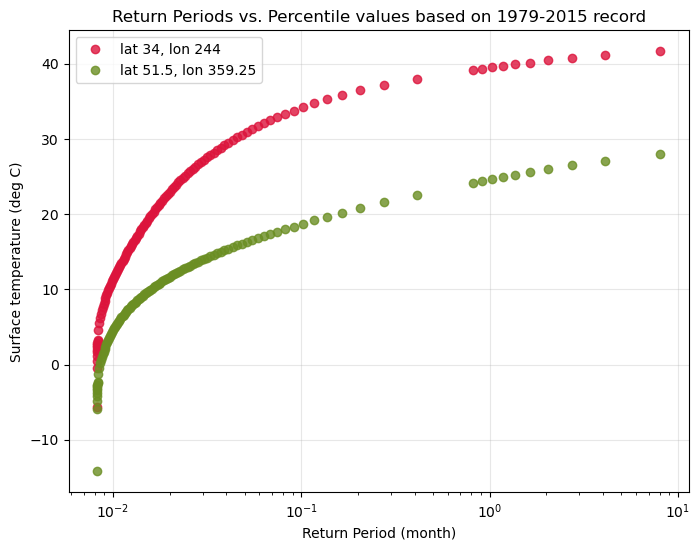

In [52]:
# Plot return periods vs. the percentile value (2t) for each grid cell
fig,ax = plt.subplots(figsize=(8,6))
for ind, (lat, lon) in enumerate(grid_cell_latlon):
    rp_for_grid_cell = return_periods[f'lat{lat}_lon{lon}']
    # print(min(rp_for_grid_cell.values()), max(rp_for_grid_cell.values()))
    with open(get_percentile_values_fp(lat,lon), 'r') as f:
        pct_dict = json.load(f)
    pct_values = [pct_dict[str(p)] for p in percentiles]
    rp_values = [rp_for_grid_cell[k] for k in rp_for_grid_cell.keys()] 
    # convert the years to months
    for i in range(len(rp_values)):
        if not np.isnan(rp_values[i]):
            rp_values[i] = rp_values[i] * 12

    # convert kelvin to celcius
    for i in range(len(pct_values)):
        pct_values[i] = pct_values[i] - 273.15

    ax.plot(rp_values[:-1], pct_values[:-1], 'o', color=colors[ind], label=f'lat {lat}, lon {lon}', alpha=0.8)

ax.set_xscale('log')
ax.set_xlabel('Average Return Period (month)')
ax.set_ylabel(f'Surface temperature (deg C)')
ax.set_title(f'Return Periods vs. Percentile values based on 1979-2015 record')
ax.legend()
ax.grid(alpha=0.3)
plt.savefig(f'./figs/return_periods_{var}_comparison.png', dpi=300)
plt.show()


### does it make sense for the return periods to be the same for two different locations?

In [49]:
rp_for_grid_cell

{np.float64(0.0): np.float64(0.00068447535888708),
 np.float64(0.1): np.float64(0.0006851724968056147),
 np.float64(0.2): np.float64(0.0006858583424472168),
 np.float64(0.3): np.float64(0.0006865455625034791),
 np.float64(0.4): np.float64(0.0006872341611099761),
 np.float64(0.5): np.float64(0.0006879241424188901),
 np.float64(0.6): np.float64(0.0006886155105990955),
 np.float64(0.7): np.float64(0.0006893082698362427),
 np.float64(0.8): np.float64(0.0006900024243328423),
 np.float64(0.9): np.float64(0.00069069797830835),
 np.float64(1.0): np.float64(0.0006913949359992525),
 np.float64(2.0): np.float64(0.0006984426616328457),
 np.float64(3.0): np.float64(0.0007056490063699127),
 np.float64(4.0): np.float64(0.0007130056076927524),
 np.float64(5.0): np.float64(0.0007205031838451502),
 np.float64(6.0): np.float64(0.0007281744469810281),
 np.float64(7.0): np.float64(0.0007359961807765754),
 np.float64(8.0): np.float64(0.0007440027347127546),
 np.float64(9.0): np.float64(0.0007521701124189384

lat 34 lon 244
0.00068447535888708 37.0
lat 51.5 lon 359.25
0.00068447535888708 37.0


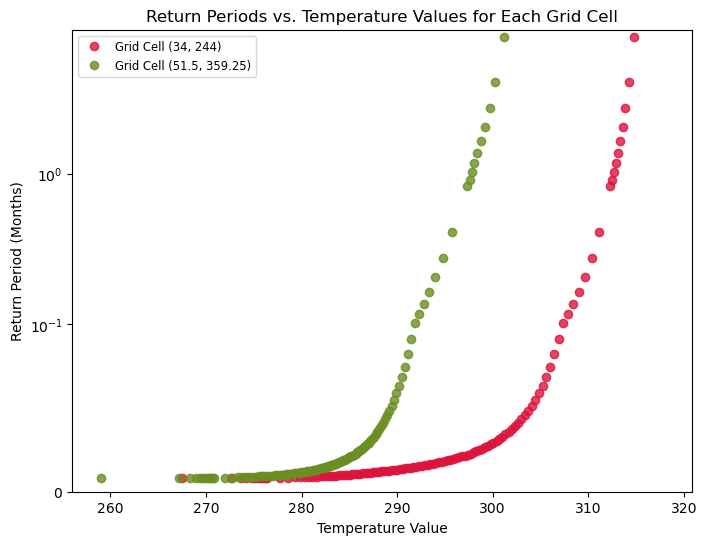

In [53]:
# # Plot return periods vs. the temperature value for each grid cell
# fig, ax = plt.subplots(figsize=(8, 6))
# for ind, (lat, lon) in enumerate(grid_cell_latlon):
#     print('lat', lat, 'lon', lon)
#     rp_for_grid_cell = return_periods[f'lat{lat}_lon{lon}']
#     print(min(rp_for_grid_cell.values()), max(rp_for_grid_cell.values())) ### RESUME HERE: WHY ARE THE RETURN PERIODS THE SAME FOR THE TWO LOCATIONS??
    
#     # Extract temperature values (percentile values) and return periods
#     p_values = [float(k) for k in rp_for_grid_cell.keys()]  # percentiles
#     with open(get_percentile_values_fp(lat,lon), 'r') as f:
#         pct_dict = json.load(f)
#     temp_values = [pct_dict[str(p)] for p in p_values]
#     rp_values = [rp_for_grid_cell[k] for k in rp_for_grid_cell.keys()]
    
#     # Convert the years to months
#     for i in range(len(rp_values)):
#         if not np.isnan(rp_values[i]):
#             rp_values[i] *= 12  # Convert years to months
    
#     # Plot temperature values vs. return periods
#     ax.plot(temp_values, rp_values, label=f'Grid Cell ({lat}, {lon})', color=colors[ind], marker='o', linestyle='None', alpha=0.8)

# ax.set_xlabel('Temperature Value')
# ax.set_ylabel('Return Period (Months)')
# ax.set_ylim(0,9)
# ax.set_yscale('symlog', linthresh=0.1)
# ax.set_title('Return Periods vs. Temperature Values for Each Grid Cell')
# ax.legend(loc='upper left', fontsize='small')
# plt.show()

### Related code below


In [4]:
six_hourly_dir

'/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data/6_hourly/msl/'

In [5]:
# CODE FOR EXTRACTING 6-HOURLY DATA FROM 1-HOURLY DATASETS

training_dir = '/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data/'
file_names = [path for path in os.listdir(training_dir) if not os.path.isdir(path) and path.endswith('.nc')]
file_names.sort()
# start from 200405 onwards
file_names = [f for f in file_names if f >= 'e5_msl_200405.nc']
print(min(file_names), max(file_names))

for ind, f in enumerate(file_names):
    fp = os.path.join('/projectnb/eb-general/shared_data/data/processed/FourCastNet_sfno/ERA5/training_data', f)
    ds = xr.open_dataset(fp,engine="netcdf4")

    # print(f)
    # print('t0', ds.isel(time=0).time.values, 't-1', ds.isel(time=-1).time.values, 'dt', np.diff(ds.time.values[:2])/np.timedelta64(1,'h'), ' hours')
    # print('datavars', list(ds.data_vars))
    # print('datadims', ds.dims)
    list(ds.data_vars).remove('utc_date')
    data_var_of_interest = list(ds.data_vars)[0]
    descrip = ds[data_var_of_interest].attrs
    # print(descrip)
    # print()

    # select only every 6 hourly timestamp, given that the data is stored in ds.time and the ds.time array has dtype='datetime64[ns]'
    hours = ds.time.dt.hour
    # time snapshots at 0000, 0600, 1200, 1800, UTC so where hours is 0, 6, 12, or 18
    mask = (hours == 0) | (hours == 6) | (hours == 12) | (hours == 18)
    # print(mask)
    six_hourly_times = ds.time.where(mask, drop=True)
    # print('six_hourly_times', six_hourly_times.values, 'dt', np.diff(six_hourly_times.values[:2])/np.timedelta64(1,'h'), ' hours')
    ds_6hourly = ds.sel(time=six_hourly_times)
    if ind % 100 == 0:
        print(ds_6hourly)
    
    # save to the six_hourly_dir
    ds_6hourly.to_netcdf(os.path.join(six_hourly_dir, f))
    

e5_msl_200405.nc e5_msl_201512.nc
<xarray.Dataset> Size: 515MB
Dimensions:    (time: 124, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 992B 2004-05-01 ... 2004-05-31T18:00:00
Data variables:
    MSL        (time, latitude, longitude) float32 515MB ...
    utc_date   (time) int32 496B ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.3
    CONVERSION_PLATFORM:  Linux r9i4n30 4.12.14-94.41-default #1 SMP Wed Oct ...
    CONVERSION_DATE:      Mon Aug  5 12:13:27 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Aug  5 12:13:44 2019: ncks -4 -

/projectnb/eb-general/wade/.conda/envs/dl/lib/python3.12/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


<xarray.Dataset> Size: 498MB
Dimensions:    (time: 120, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 960B 2012-09-01 ... 2012-09-30T18:00:00
Data variables:
    MSL        (time, latitude, longitude) float32 498MB ...
    utc_date   (time) int32 480B ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.3
    CONVERSION_PLATFORM:  Linux r14i3n7 4.12.14-94.41-default #1 SMP Wed Oct ...
    CONVERSION_DATE:      Mon Aug 26 16:44:15 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Aug 26 16:44:32 2019: ncks -4 --ppc default=7 e...
    NCO:      

In [12]:
# CODE FOR LOADING SFNO DATA FROM ERA5 FOR A GIVEN TIMESTEP RANGE
# steps are 6-hourly (e.g. 12 steps = 3 days)
n_steps = 12

# Open and load the JSON file
SFNO_dir = '/projectnb/eb-general/shared_data/data/processed/sfno/'
data_fp = os.path.join(SFNO_dir,'ERA5_SFNO','data.json')

# open initial conditions from stored ERA data
later_str = (datetime.fromisoformat(timestep_select) + timedelta(hours = n_steps*6)).isoformat() 
print(f"Selecting timestep {timestep_select} to {later_str}")

with open(data_fp, 'r') as f:
    labels = json.load(f)

# open initial conditions from stored ERA data
timestep_select = '2021-06-27T00:00:00'
year_of_timestep = datetime.fromisoformat(timestep_select).year
data_create = open_hdf5(path = os.path.join(SFNO_dir, 'ERA5_SFNO',str(year_of_timestep)+'.h5'), metadata = labels)
data_create = data_create.sel(time = [timestep_select, later_str]) # this just selects the first and last time in the time range
data_create = data_create.rename({"channel": "variable"})
data_create


NameError: name 'timestep_select' is not defined

In [4]:
# open testing data (file of a whole year of data formatted for the sfno model) 
# at /projectnb/eb-general/shared_data/data/processed/sfno/ERA5_SFNO/2019.h5
ds = xr.open_dataset('/projectnb/eb-general/shared_data/data/processed/sfno/ERA5_SFNO/2019.h5', engine='h5netcdf')
print(ds)

/scratch/375941.1.ood/ipykernel_826948/2635312399.py:2: UserWarning: The 'phony_dims' kwarg now defaults to 'access'. Previously 'phony_dims=None' would raise an error. For full netcdf equivalence please use phony_dims='sort'.
  ds = xr.open_dataset('/projectnb/eb-general/shared_data/data/processed/sfno/ERA5_SFNO/2019.h5', engine='h5netcdf')


<xarray.Dataset> Size: 449GB
Dimensions:  (phony_dim_0: 1460, phony_dim_1: 74, phony_dim_2: 721,
              phony_dim_3: 1440)
Dimensions without coordinates: phony_dim_0, phony_dim_1, phony_dim_2,
                                phony_dim_3
Data variables:
    fields   (phony_dim_0, phony_dim_1, phony_dim_2, phony_dim_3) float32 449GB ...
